# Fisheries competition

In this notebook we're going to investigate a range of different architectures for the [Kaggle fisheries competition](https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring/).  The video states that vgg.py and ``vgg_ft()`` from utils.py have been updated to include VGG with batch normalization, but this is not the case.  We've instead created a new file [vgg_bn.py](https://github.com/fastai/courses/blob/master/deeplearning1/nbs/vgg16bn.py) and an additional method ``vgg_ft_bn()`` (which is already in utils.py) which we use in this notebook.

In [1]:
from theano.sandbox import cuda

from importlib import reload

%matplotlib inline
import utils; reload(utils)
from utils import *
from __future__ import division, print_function

Using gpu device 0: GeForce GTX 1060 6GB (CNMeM is enabled with initial size: 90.0% of memory, cuDNN 5105)
/home/fehiepsi/miniconda3/envs/pydata/lib/python3.5/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


In [4]:
#path = "data/fish/sample/"
path = "data/fish/"
batch_size=64

batches = get_batches(path+'train', batch_size=batch_size)
val_batches = get_batches(path+'valid', batch_size=batch_size*2, shuffle=False)

(val_classes, trn_classes, val_labels, trn_labels, 
    val_filenames, filenames, test_filenames) = get_classes(path)

Found 3277 images belonging to 8 classes.
Found 500 images belonging to 8 classes.
Found 3277 images belonging to 8 classes.
Found 500 images belonging to 8 classes.
Found 1000 images belonging to 1 classes.


Sometimes it's helpful to have just the filenames, without the path.

In [5]:
raw_filenames = [f.split('/')[-1] for f in filenames]
raw_test_filenames = [f.split('/')[-1] for f in test_filenames]
raw_val_filenames = [f.split('/')[-1] for f in val_filenames]

## Setup dirs

We create the validation and sample sets in the usual way.

In [3]:
if 1 == 0:
    %cd data/fish
    %cd train
    %mkdir ../valid

    g = glob('*')
    for d in g: os.mkdir('../valid/'+d)

    g = glob('*/*.jpg')
    shuf = np.random.permutation(g)
    for i in range(500): os.rename(shuf[i], '../valid/' + shuf[i])

    %mkdir ../sample
    %mkdir ../sample/train
    %mkdir ../sample/valid

    from shutil import copyfile

    g = glob('*')
    for d in g: 
        os.mkdir('../sample/train/'+d)
        os.mkdir('../sample/valid/'+d)

    g = glob('*/*.jpg')
    shuf = np.random.permutation(g)
    for i in range(400): copyfile(shuf[i], '../sample/train/' + shuf[i])

    %cd ../valid

    g = glob('*/*.jpg')
    shuf = np.random.permutation(g)
    for i in range(200): copyfile(shuf[i], '../sample/valid/' + shuf[i])

    %cd ..

    %mkdir results
    %mkdir sample/results
    %cd ../..

/home/fehiepsi/Projects/courses/deeplearning1/nbs/data/fish
/home/fehiepsi/Projects/courses/deeplearning1/nbs/data/fish/train
/home/fehiepsi/Projects/courses/deeplearning1/nbs/data/fish/valid
/home/fehiepsi/Projects/courses/deeplearning1/nbs/data/fish
mkdir: cannot create directory ‘results’: File exists
/home/fehiepsi/Projects/courses/deeplearning1/nbs


## Basic VGG

We start with our usual VGG approach.  We will be using VGG with batch normalization.  We explained how to add batch normalization to VGG in the [imagenet_batchnorm notebook](https://github.com/fastai/courses/blob/master/deeplearning1/nbs/imagenet_batchnorm.ipynb).  VGG with batch normalization is implemented in [vgg_bn.py](https://github.com/fastai/courses/blob/master/deeplearning1/nbs/vgg16bn.py), and there is a version of ``vgg_ft`` (our fine tuning function) with batch norm called ``vgg_ft_bn`` in [utils.py](https://github.com/fastai/courses/blob/master/deeplearning1/nbs/utils.py).

### Initial model

First we create a simple fine-tuned VGG model to be our starting point.

In [6]:
if 1 == 0:
    trn = get_data(path+'train')

    val = get_data(path+'valid')

    test = get_data(path+'test')

    save_array(path+'results/trn.dat', trn)
    save_array(path+'results/val.dat', val)

    save_array(path+'results/test.dat', test)
else:
    trn = load_array(path+'results/trn.dat')
    val = load_array(path+'results/val.dat')

    test = load_array(path+'results/test.dat')

Found 3277 images belonging to 8 classes.
Found 500 images belonging to 8 classes.
Found 1000 images belonging to 1 classes.


### Precompute convolutional output

We pre-compute the output of the last convolution layer of VGG, since we're unlikely to need to fine-tune those layers. (All following analysis will be done on just the pre-computed convolutional features.)

In [7]:
from vgg16bn import Vgg16BN
model = vgg_ft_bn(8)

model.compile(optimizer=Adam(1e-3),
              loss='categorical_crossentropy', metrics=['accuracy'])

if 1 == 0:
    model.fit(trn, trn_labels, batch_size=batch_size,
              nb_epoch=3, verbose=2,
              validation_data=(val, val_labels))

    model.save_weights(path+'results/ft1.h5')
else:
    model.load_weights(path+'results/ft1.h5')

conv_layers, fc_layers = split_at(model, Convolution2D)

/home/fehiepsi/miniconda3/envs/pydata/lib/python3.5/site-packages/keras/layers/core.py:577: UserWarning: `output_shape` argument not specified for layer lambda_1 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 224, 224)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


Train on 3277 samples, validate on 500 samples
Epoch 1/3
52s - loss: 2.8158 - acc: 0.4690 - val_loss: 1.1783 - val_acc: 0.6840
Epoch 2/3
52s - loss: 1.5765 - acc: 0.6607 - val_loss: 0.6524 - val_acc: 0.8100
Epoch 3/3
52s - loss: 1.1916 - acc: 0.7238 - val_loss: 0.5513 - val_acc: 0.8320


In [8]:
if 1 == 1:
    conv_model = Sequential(conv_layers)

    conv_feat = conv_model.predict(trn)
    conv_val_feat = conv_model.predict(val)

    conv_test_feat = conv_model.predict(test)

    save_array(path+'results/conv_val_feat.dat', conv_val_feat)
    save_array(path+'results/conv_feat.dat', conv_feat)

    save_array(path+'results/conv_test_feat.dat', conv_test_feat)
else:
    conv_feat = load_array(path+'results/conv_feat.dat')
    conv_val_feat = load_array(path+'results/conv_val_feat.dat')

    conv_test_feat = load_array(path+'results/conv_test_feat.dat')

conv_val_feat.shape

(500, 512, 14, 14)

### Train model

We can now create our first baseline model - a simple 3-layer FC net.

In [10]:
if 1 == 1:
    def get_bn_layers(p):
        return [
            MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
            BatchNormalization(axis=1),
            Dropout(p/4),
            Flatten(),
            Dense(512, activation='relu'),
            BatchNormalization(),
            Dropout(p),
            Dense(512, activation='relu'),
            BatchNormalization(),
            Dropout(p/2),
            Dense(8, activation='softmax')
        ]

    p=0.6

    bn_model = Sequential(get_bn_layers(p))

    bn_model.compile(Adam(lr=0.001), loss='categorical_crossentropy',
                     metrics=['accuracy'])

    if 1 == 1:
        bn_model.fit(conv_feat, trn_labels, batch_size=batch_size,
                     nb_epoch=3, verbose=2,
                     validation_data=(conv_val_feat, val_labels))

        bn_model.optimizer.lr = 1e-4

        bn_model.fit(conv_feat, trn_labels, batch_size=batch_size,
                     nb_epoch=7, verbose=2, 
                     validation_data=(conv_val_feat, val_labels))

        bn_model.save_weights(path+'results/conv_512_6.h5')

        bn_model.evaluate(conv_val_feat, val_labels)
    else:
        bn_model.load_weights(path+'results/conv_512_6.h5')

Train on 3277 samples, validate on 500 samples
Epoch 1/3
1s - loss: 1.0974 - acc: 0.6903 - val_loss: 0.6562 - val_acc: 0.8880
Epoch 2/3
1s - loss: 0.2999 - acc: 0.9112 - val_loss: 0.1995 - val_acc: 0.9560
Epoch 3/3
1s - loss: 0.1883 - acc: 0.9512 - val_loss: 0.1195 - val_acc: 0.9780
Train on 3277 samples, validate on 500 samples
Epoch 1/7
1s - loss: 0.0978 - acc: 0.9731 - val_loss: 0.1246 - val_acc: 0.9760
Epoch 2/7
1s - loss: 0.0642 - acc: 0.9826 - val_loss: 0.1256 - val_acc: 0.9740
Epoch 3/7
1s - loss: 0.0530 - acc: 0.9835 - val_loss: 0.1296 - val_acc: 0.9720
Epoch 4/7
1s - loss: 0.0456 - acc: 0.9881 - val_loss: 0.1201 - val_acc: 0.9800
Epoch 5/7
1s - loss: 0.0445 - acc: 0.9912 - val_loss: 0.1176 - val_acc: 0.9760
Epoch 6/7
1s - loss: 0.0448 - acc: 0.9887 - val_loss: 0.1430 - val_acc: 0.9720
Epoch 7/7
0s - loss: 0.0397 - acc: 0.9893 - val_loss: 0.1357 - val_acc: 0.9800
480/500 [===========================>..] - ETA: 0s

## Multi-input

The images are of different sizes, which are likely to represent the boat they came from (since different boats will use different cameras). Perhaps this creates some data leakage that we can take advantage of to get a better Kaggle leaderboard position? To find out, first we create arrays of the file sizes for each image:

In [8]:
sizes = [PIL.Image.open(path+'train/'+f).size for f in filenames]
id2size = list(set(sizes))
size2id = {o:i for i,o in enumerate(id2size)}

import collections
collections.Counter(sizes)

Counter({(1192, 670): 169,
         (1244, 700): 25,
         (1276, 718): 188,
         (1280, 720): 1867,
         (1280, 750): 528,
         (1280, 924): 49,
         (1280, 974): 353,
         (1334, 750): 30,
         (1518, 854): 36,
         (1732, 974): 32})

Then we one-hot encode them (since we want to treat them as categorical) and normalize the data.

In [9]:
trn_sizes_orig = to_categorical([size2id[o] for o in sizes], len(id2size))

raw_val_sizes = [PIL.Image.open(path+'valid/'+f).size for f in val_filenames]
val_sizes = to_categorical([size2id[o] for o in raw_val_sizes], len(id2size))

trn_sizes = trn_sizes_orig-trn_sizes_orig.mean(axis=0)/trn_sizes_orig.std(axis=0)
val_sizes = val_sizes-trn_sizes_orig.mean(axis=0)/trn_sizes_orig.std(axis=0)

To use this additional "meta-data", we create a model with multiple input layers - `sz_inp` will be our input for the size information.

When we compile the model, we have to specify all the input layers in an array.

And when we train the model, we have to provide all the input layers' data in an array.

In [20]:
if 1 == 0:
    p=0.6

    inp = Input(conv_layers[-1].output_shape[1:])
    sz_inp = Input((len(id2size),))
    bn_inp = BatchNormalization()(sz_inp)

    x = MaxPooling2D()(inp)
    x = BatchNormalization(axis=1)(x)
    x = Dropout(p/4)(x)
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(p)(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(p/2)(x)
    x = merge([x,bn_inp], 'concat')
    x = Dense(8, activation='softmax')(x)

    leak_model = Model([inp, sz_inp], x)
    leak_model.compile(Adam(lr=0.001), loss='categorical_crossentropy',
                       metrics=['accuracy'])

    leak_model.fit([conv_feat, trn_sizes], trn_labels, batch_size=batch_size,
                   nb_epoch=3, verbose=2,
                   validation_data=([conv_val_feat, val_sizes], val_labels))

    leak_model.optimizer.lr = 1e-4

    leak_model.fit([conv_feat, trn_sizes], trn_labels, batch_size=batch_size,
                   nb_epoch=8, verbose=2,
                   validation_data=([conv_val_feat, val_sizes], val_labels))

Train on 3277 samples, validate on 500 samples
Epoch 1/3
1s - loss: 1.1433 - acc: 0.6674 - val_loss: 0.9241 - val_acc: 0.8680
Epoch 2/3
1s - loss: 0.3242 - acc: 0.9081 - val_loss: 0.3294 - val_acc: 0.9340
Epoch 3/3
1s - loss: 0.1710 - acc: 0.9509 - val_loss: 0.1761 - val_acc: 0.9620
Train on 3277 samples, validate on 500 samples
Epoch 1/8
1s - loss: 0.1024 - acc: 0.9683 - val_loss: 0.1718 - val_acc: 0.9660
Epoch 2/8
1s - loss: 0.0754 - acc: 0.9817 - val_loss: 0.1290 - val_acc: 0.9780
Epoch 3/8
1s - loss: 0.0560 - acc: 0.9838 - val_loss: 0.1310 - val_acc: 0.9780
Epoch 4/8
1s - loss: 0.0549 - acc: 0.9850 - val_loss: 0.1358 - val_acc: 0.9780
Epoch 5/8
1s - loss: 0.0663 - acc: 0.9817 - val_loss: 0.1280 - val_acc: 0.9780
Epoch 6/8
1s - loss: 0.0502 - acc: 0.9872 - val_loss: 0.1235 - val_acc: 0.9780
Epoch 7/8
1s - loss: 0.0625 - acc: 0.9854 - val_loss: 0.1438 - val_acc: 0.9760
Epoch 8/8
1s - loss: 0.0653 - acc: 0.9844 - val_loss: 0.1405 - val_acc: 0.9720


The model did not show an improvement by using the leakage, other than in the early epochs. This is most likely because the information about what boat the picture came from is readily identified from the image itself, so the meta-data turned out not to add any additional information.

## Bounding boxes & multi output

### Import / view bounding boxes

A kaggle user has created bounding box annotations for each fish in each training set image. You can download them [from here](https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring/forums/t/25902/complete-bounding-box-annotation). We will see if we can utilize this additional information. First, we'll load in the data, and keep just the largest bounding box for each image.

In [23]:
import ujson as json

In [24]:
anno_classes = ['alb', 'bet', 'dol', 'lag', 'other', 'shark', 'yft']

In [25]:
bb_json = {}
for c in anno_classes:
    j = json.load(open('{}annos/{}_labels.json'.format(path, c), 'r'))
    for l in j:
        if 'annotations' in l.keys() and len(l['annotations'])>0:
            bb_json[l['filename'].split('/')[-1]] = sorted(
                l['annotations'], key=lambda x: x['height']*x['width'])[-1]

In [26]:
bb_json['img_04908.jpg']

{'class': 'rect',
 'height': 246.75000000000074,
 'width': 432.8700000000013,
 'x': 465.3000000000014,
 'y': 496.32000000000147}

In [27]:
file2idx = {o:i for i,o in enumerate(raw_filenames)}
val_file2idx = {o:i for i,o in enumerate(raw_val_filenames)}

For any images that have no annotations, we'll create an empty bounding box.

In [28]:
empty_bbox = {'height': 0., 'width': 0., 'x': 0., 'y': 0.}

In [29]:
for f in raw_filenames:
    if not f in bb_json.keys(): bb_json[f] = empty_bbox
for f in raw_val_filenames:
    if not f in bb_json.keys(): bb_json[f] = empty_bbox

Finally, we convert the dictionary into an array, and convert the coordinates to our resized 224x224 images.

In [30]:
bb_params = ['height', 'width', 'x', 'y']
def convert_bb(bb, size):
    bb = [bb[p] for p in bb_params]
    conv_x = (224. / size[0])
    conv_y = (224. / size[1])
    bb[0] = bb[0]*conv_y
    bb[1] = bb[1]*conv_x
    bb[2] = max(bb[2]*conv_x, 0)
    bb[3] = max(bb[3]*conv_y, 0)
    return bb

In [31]:
trn_bbox = np.stack([convert_bb(bb_json[f], s) for f,s in zip(raw_filenames, sizes)], 
                   ).astype(np.float32)
val_bbox = np.stack([convert_bb(bb_json[f], s) 
                   for f,s in zip(raw_val_filenames, raw_val_sizes)]).astype(np.float32)

Now we can check our work by drawing one of the annotations.

In [32]:
def create_rect(bb, color='red'):
    return plt.Rectangle((bb[2], bb[3]), bb[1], bb[0], color=color, fill=False, lw=3)

def show_bb(i):
    bb = val_bbox[i]
    plot(val[i])
    plt.gca().add_patch(create_rect(bb))

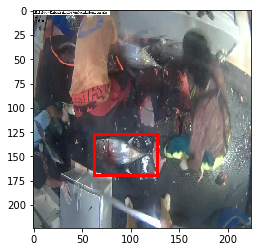

In [33]:
show_bb(0)

### Create & train model

Since we're not allowed (by the kaggle rules) to manually annotate the test set, we'll need to create a model that predicts the locations of the bounding box on each image. To do so, we create a model with multiple outputs: it will predict both the type of fish (the 'class'), and the 4 bounding box coordinates. We prefer this approach to only predicting the bounding box coordinates, since we hope that giving the model more context about what it's looking for will help it with both tasks.

In [34]:
p=0.6

In [35]:
inp = Input(conv_layers[-1].output_shape[1:])
x = MaxPooling2D()(inp)
x = BatchNormalization(axis=1)(x)
x = Dropout(p/4)(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p/2)(x)
x_bb = Dense(4, name='bb')(x)
x_class = Dense(8, activation='softmax', name='class')(x)

Since we have multiple outputs, we need to provide them to the model constructor in an array, and we also need to say what loss function to use for each. We also weight the bounding box loss function down by 1000x since the scale of the cross-entropy loss and the MSE is very different.

In [36]:
model = Model([inp], [x_bb, x_class])
model.compile(Adam(lr=0.001), loss=['mse', 'categorical_crossentropy'],
              metrics=['accuracy'],
              loss_weights=[.001, 1.])

In [38]:
model.fit(conv_feat, [trn_bbox, trn_labels], batch_size=batch_size,
          nb_epoch=3, verbose=2,
          validation_data=(conv_val_feat, [val_bbox, val_labels]))

INFO (theano.gof.compilelock): Refreshing lock /home/fehiepsi/.theano/compiledir_Linux-4.4--generic-x86_64-with-debian-stretch-sid-x86_64-3.5.2-64/lock_dir/lock


Train on 3277 samples, validate on 500 samples
Epoch 1/3
1s - loss: 6.1858 - bb_loss: 5036.6528 - class_loss: 1.1491 - bb_acc: 0.4214 - class_acc: 0.6665 - val_loss: 4.4455 - val_bb_loss: 3880.4837 - val_class_loss: 0.5650 - val_bb_acc: 0.6140 - val_class_acc: 0.8900
Epoch 2/3
0s - loss: 5.0812 - bb_loss: 4750.1064 - class_loss: 0.3311 - bb_acc: 0.5029 - class_acc: 0.9072 - val_loss: 4.0315 - val_bb_loss: 3817.8681 - val_class_loss: 0.2136 - val_bb_acc: 0.5980 - val_class_acc: 0.9540
Epoch 3/3
0s - loss: 4.4335 - bb_loss: 4279.4714 - class_loss: 0.1540 - bb_acc: 0.5325 - class_acc: 0.9512 - val_loss: 3.6481 - val_bb_loss: 3475.9044 - val_class_loss: 0.1721 - val_bb_acc: 0.6180 - val_class_acc: 0.9660


In [39]:
model.optimizer.lr = 1e-5

In [40]:
model.fit(conv_feat, [trn_bbox, trn_labels], batch_size=batch_size,
          nb_epoch=10, verbose=2,
          validation_data=(conv_val_feat, [val_bbox, val_labels]))

Train on 3277 samples, validate on 500 samples
Epoch 1/10
1s - loss: 3.7245 - bb_loss: 3620.9957 - class_loss: 0.1035 - bb_acc: 0.5752 - class_acc: 0.9725 - val_loss: 3.1327 - val_bb_loss: 2951.9386 - val_class_loss: 0.1808 - val_bb_acc: 0.6520 - val_class_acc: 0.9700
Epoch 2/10
0s - loss: 2.9455 - bb_loss: 2872.5231 - class_loss: 0.0730 - bb_acc: 0.6182 - class_acc: 0.9802 - val_loss: 2.5070 - val_bb_loss: 2326.4061 - val_class_loss: 0.1806 - val_bb_acc: 0.6720 - val_class_acc: 0.9580
Epoch 3/10
0s - loss: 2.1137 - bb_loss: 2051.2716 - class_loss: 0.0624 - bb_acc: 0.6671 - class_acc: 0.9826 - val_loss: 1.7706 - val_bb_loss: 1612.8803 - val_class_loss: 0.1577 - val_bb_acc: 0.6940 - val_class_acc: 0.9700
Epoch 4/10
0s - loss: 1.3539 - bb_loss: 1294.5660 - class_loss: 0.0593 - bb_acc: 0.7116 - class_acc: 0.9854 - val_loss: 1.1577 - val_bb_loss: 980.8605 - val_class_loss: 0.1768 - val_bb_acc: 0.7440 - val_class_acc: 0.9740
Epoch 5/10
0s - loss: 0.7826 - bb_loss: 736.4511 - class_loss: 0.0

Excitingly, it turned out that the classification model is much improved by giving it this additional task. Let's see how well the bounding box model did by taking a look at its output.

In [41]:
pred = model.predict(conv_val_feat[0:10])

INFO (theano.gof.compilelock): Refreshing lock /home/fehiepsi/.theano/compiledir_Linux-4.4--generic-x86_64-with-debian-stretch-sid-x86_64-3.5.2-64/lock_dir/lock


In [42]:
def show_bb_pred(i):
    bb = val_bbox[i]
    bb_pred = pred[0][i]
    plt.figure(figsize=(6,6))
    plot(val[i])
    ax=plt.gca()
    ax.add_patch(create_rect(bb_pred, 'yellow'))
    ax.add_patch(create_rect(bb))

The image shows that it can find fish that are tricky for us to see!

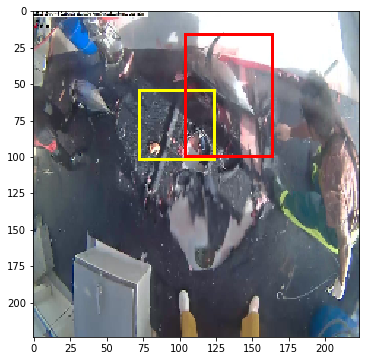

In [43]:
show_bb_pred(6)

In [44]:
model.evaluate(conv_val_feat, [val_bbox, val_labels])

480/500 [===========================>..] - ETA: 0s

[0.37604021263122561,
 226.74802770996095,
 0.14929217479890211,
 0.82800000047683719,
 0.97399999999999998]

In [45]:
model.save_weights(path+'results/bn_anno.h5')

In [57]:
model.load_weights(path+'results/bn_anno.h5')

## Larger size

### Set up data

Let's see if we get better results if we use larger images. We'll use 640x360, since it's the same shape as the most common size we saw earlier (1280x720), without being too big.

In [4]:
trn = get_data(path+'train', (360,640))
val = get_data(path+'valid', (360,640))

Found 3277 images belonging to 8 classes.


MemoryError: 

The image shows that things are much clearer at this size.

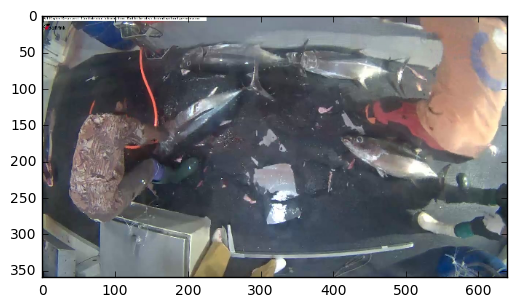

In [70]:
plot(trn[0])

In [71]:
test = get_data(path+'test', (360,640))

Found 1000 images belonging to 1 classes.


In [72]:
save_array(path+'results/trn_640.dat', trn)
save_array(path+'results/val_640.dat', val)

In [73]:
save_array(path+'results/test_640.dat', test)

In [6]:
trn = load_array(path+'results/trn_640.dat')
val = load_array(path+'results/val_640.dat')

We can now create our VGG model - we'll need to tell it we're not using the normal 224x224 images, which also means it won't include the fully connected layers (since they don't make sense for non-default sizes). We will also remove the last max pooling layer, since we don't want to throw away information yet.

In [74]:
vgg640 = Vgg16BN((360, 640)).model
vgg640.pop()
vgg640.input_shape, vgg640.output_shape
vgg640.compile(Adam(), 'categorical_crossentropy', metrics=['accuracy'])

We can now pre-compute the output of the convolutional part of VGG.

In [75]:
conv_val_feat = vgg640.predict(val, batch_size=32, verbose=1)
conv_trn_feat = vgg640.predict(trn, batch_size=32, verbose=1)

3277/3277 [==============================] - 390s   


In [76]:
save_array(path+'results/conv_val_640.dat', conv_val_feat)
save_array(path+'results/conv_trn_640.dat', conv_trn_feat)

In [77]:
conv_test_feat = vgg640.predict(test, batch_size=32, verbose=1)

1000/1000 [==============================] - 115s   


In [83]:
save_array(path+'results/conv_test_640.dat', conv_test_feat)

In [10]:
conv_val_feat = load_array(path+'results/conv_val_640.dat')
conv_trn_feat = load_array(path+'results/conv_trn_640.dat')

In [868]:
conv_test_feat = load_array(path+'results/conv_test_640.dat')

### Fully convolutional net (FCN)

Since we're using a larger input, the output of the final convolutional layer is also larger. So we probably don't want to put a dense layer there - that would be a *lot* of parameters! Instead, let's use a fully convolutional net (FCN); this also has the benefit that they tend to generalize well, and also seems like a good fit for our problem (since the fish are a small part of the image).

In [78]:
conv_layers,_ = split_at(vgg640, Convolution2D)

I'm not using any dropout, since I found I got better results without it.

In [79]:
nf=128; p=0.

In [80]:
def get_lrg_layers():
    return [
        BatchNormalization(axis=1, input_shape=conv_layers[-1].output_shape[1:]),
        Convolution2D(nf,3,3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        MaxPooling2D(),
        Convolution2D(nf,3,3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        MaxPooling2D(),
        Convolution2D(nf,3,3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        MaxPooling2D((1,2)),
        Convolution2D(8,3,3, border_mode='same'),
        Dropout(p),
        GlobalAveragePooling2D(),
        Activation('softmax')
    ]

In [81]:
lrg_model = Sequential(get_lrg_layers())

In [ ]:
lrg_model.summary()

In [84]:
lrg_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
lrg_model.fit(conv_trn_feat, trn_labels, batch_size=batch_size, nb_epoch=2, 
             validation_data=(conv_val_feat, val_labels))

In [86]:
lrg_model.optimizer.lr=1e-5

In [365]:
lrg_model.fit(conv_trn_feat, trn_labels, batch_size=batch_size, nb_epoch=6, 
             validation_data=(conv_val_feat, val_labels))

Train on 3277 samples, validate on 500 samples
Epoch 1/6
3277/3277 [==============================] - 6s - loss: 0.0417 - acc: 0.9896 - val_loss: 0.2282 - val_acc: 0.9440
Epoch 2/6
3277/3277 [==============================] - 6s - loss: 0.0346 - acc: 0.9921 - val_loss: 0.1377 - val_acc: 0.9520
Epoch 3/6
3277/3277 [==============================] - 6s - loss: 0.0090 - acc: 0.9979 - val_loss: 0.1374 - val_acc: 0.9620
Epoch 4/6
3277/3277 [==============================] - 6s - loss: 0.0097 - acc: 0.9988 - val_loss: 0.1127 - val_acc: 0.9680
Epoch 5/6
3277/3277 [==============================] - 6s - loss: 0.0041 - acc: 0.9994 - val_loss: 0.0969 - val_acc: 0.9740
Epoch 6/6
3277/3277 [==============================] - 6s - loss: 8.9966e-04 - acc: 1.0000 - val_loss: 0.0976 - val_acc: 0.9760


When I submitted the results of this model to Kaggle, I got the best single model results of any shown here (ranked 22nd on the leaderboard as at Dec-6-2016.)

In [366]:
lrg_model.save_weights(path+'models/lrg_nmp.h5')

In [870]:
lrg_model.load_weights(path+'models/lrg_nmp.h5')

In [871]:
lrg_model.evaluate(conv_val_feat, val_labels)

500/500 [==============================] - 0s     


[0.097560357421636587, 0.97599999999999998]

Another benefit of this kind of model is that the last convolutional layer has to learn to classify each part of the image (since there's only an average pooling layer after). Let's create a function that grabs the output of this layer (which is the 4th-last layer of our model).

In [872]:
l = lrg_model.layers
conv_fn = K.function([l[0].input, K.learning_phase()], l[-4].output)

In [881]:
def get_cm(imp, label):
    conv = conv_fn([inp,0])[0, label]
    return scipy.misc.imresize(conv, (360,640), interp='nearest')

We have to add an extra dimension to our input since the CNN expects a 'batch' (even if it's just a batch of one).

In [882]:
inp = np.expand_dims(conv_val_feat[0], 0)
np.round(lrg_model.predict(inp)[0],2)

array([ 0.82,  0.  ,  0.  ,  0.  ,  0.17,  0.  ,  0.  ,  0.  ], dtype=float32)

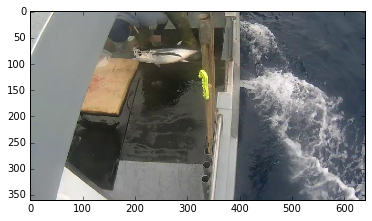

In [883]:
plt.imshow(to_plot(val[0]))

In [885]:
cm = get_cm(inp, 0)

The heatmap shows that (at very low resolution) the model is finding the fish!

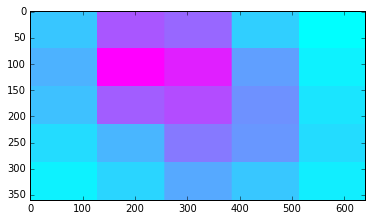

In [886]:
plt.imshow(cm, cmap="cool")

### All convolutional net heatmap

To create a higher resolution heatmap, we'll remove all the max pooling layers, and repeat the previous steps.

In [14]:
def get_lrg_layers():
    return [
        BatchNormalization(axis=1, input_shape=conv_layers[-1].output_shape[1:]),
        Convolution2D(nf,3,3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        Convolution2D(nf,3,3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        Convolution2D(nf,3,3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        Convolution2D(8,3,3, border_mode='same'),
        GlobalAveragePooling2D(),
        Activation('softmax')
    ]

In [17]:
lrg_model = Sequential(get_lrg_layers())

In [18]:
lrg_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
batchnormalization_2 (BatchNorma (None, 512, 22, 40)   1024        batchnormalization_input_1[0][0] 
____________________________________________________________________________________________________
convolution2d_14 (Convolution2D) (None, 128, 22, 40)   589952      batchnormalization_2[0][0]       
____________________________________________________________________________________________________
batchnormalization_3 (BatchNorma (None, 128, 22, 40)   256         convolution2d_14[0][0]           
____________________________________________________________________________________________________
convolution2d_15 (Convolution2D) (None, 128, 22, 40)   147584      batchnormalization_3[0][0]       
___________________________________________________________________________________________

In [19]:
lrg_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [891]:
lrg_model.fit(conv_trn_feat, trn_labels, batch_size=batch_size, nb_epoch=2, 
             validation_data=(conv_val_feat, val_labels))

Train on 3277 samples, validate on 500 samples
Epoch 1/2
3277/3277 [==============================] - 11s - loss: 0.9377 - acc: 0.7128 - val_loss: 2.7022 - val_acc: 0.6260
Epoch 2/2
3277/3277 [==============================] - 10s - loss: 0.2603 - acc: 0.9271 - val_loss: 0.4385 - val_acc: 0.9080


In [892]:
lrg_model.optimizer.lr=1e-5

In [893]:
lrg_model.fit(conv_trn_feat, trn_labels, batch_size=batch_size, nb_epoch=6, 
             validation_data=(conv_val_feat, val_labels))

Train on 3277 samples, validate on 500 samples
Epoch 1/6
3277/3277 [==============================] - 11s - loss: 0.1027 - acc: 0.9747 - val_loss: 0.3641 - val_acc: 0.9060
Epoch 2/6
3277/3277 [==============================] - 10s - loss: 0.0498 - acc: 0.9844 - val_loss: 0.2743 - val_acc: 0.9200
Epoch 3/6
3277/3277 [==============================] - 10s - loss: 0.0359 - acc: 0.9918 - val_loss: 0.2262 - val_acc: 0.9520
Epoch 4/6
3277/3277 [==============================] - 11s - loss: 0.0339 - acc: 0.9912 - val_loss: 0.1877 - val_acc: 0.9540
Epoch 5/6
3277/3277 [==============================] - 10s - loss: 0.0242 - acc: 0.9945 - val_loss: 0.2320 - val_acc: 0.9460
Epoch 6/6
3277/3277 [==============================] - 10s - loss: 0.0211 - acc: 0.9930 - val_loss: 0.1813 - val_acc: 0.9520


In [894]:
lrg_model.save_weights(path+'models/lrg_0mp.h5')

In [20]:
lrg_model.load_weights(path+'models/lrg_0mp.h5')

#### Create heatmap

In [21]:
l = lrg_model.layers
conv_fn = K.function([l[0].input, K.learning_phase()], l[-3].output)

In [22]:
def get_cm2(imp, label):
    conv = conv_fn([inp,0])[0, label]
    return scipy.misc.imresize(conv, (360,640))

In [23]:
inp = np.expand_dims(conv_val_feat[0], 0)

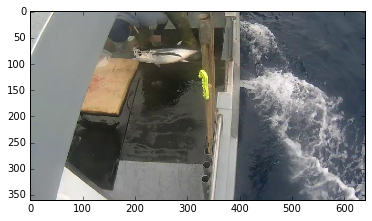

In [900]:
plt.imshow(to_plot(val[0]))

In [912]:
cm = get_cm2(inp, 0)

In [24]:
cm = get_cm2(inp, 4)

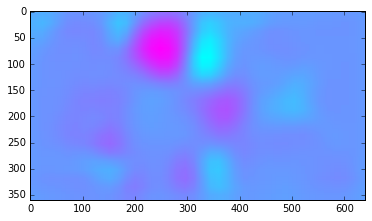

In [913]:
plt.imshow(cm, cmap="cool")

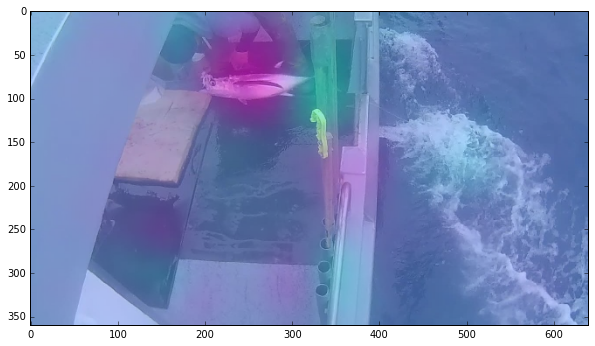

In [903]:
plt.figure(figsize=(10,10))
plot(val[0])
plt.imshow(cm, cmap="cool", alpha=0.5)

### Inception mini-net

Here's an example of how to create and use "inception blocks" - as you see, they use multiple different convolution filter sizes and concatenate the results together. We'll talk more about these next year.

In [198]:
def conv2d_bn(x, nb_filter, nb_row, nb_col, subsample=(1, 1)):
    x = Convolution2D(nb_filter, nb_row, nb_col,
                      subsample=subsample, activation='relu', border_mode='same')(x)
    return BatchNormalization(axis=1)(x)

In [208]:
def incep_block(x):
    branch1x1 = conv2d_bn(x, 32, 1, 1, subsample=(2, 2))
    branch5x5 = conv2d_bn(x, 24, 1, 1)
    branch5x5 = conv2d_bn(branch5x5, 32, 5, 5, subsample=(2, 2))

    branch3x3dbl = conv2d_bn(x, 32, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 48, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 48, 3, 3, subsample=(2, 2))

    branch_pool = AveragePooling2D(
        (3, 3), strides=(2, 2), border_mode='same')(x)
    branch_pool = conv2d_bn(branch_pool, 16, 1, 1)
    return merge([branch1x1, branch5x5, branch3x3dbl, branch_pool],
              mode='concat', concat_axis=1)

In [271]:
inp = Input(vgg640.layers[-1].output_shape[1:]) 
x = BatchNormalization(axis=1)(inp)
x = incep_block(x)
x = incep_block(x)
x = incep_block(x)
x = Dropout(0.75)(x)
x = Convolution2D(8,3,3, border_mode='same')(x)
x = GlobalAveragePooling2D()(x)
outp = Activation('softmax')(x)

In [272]:
lrg_model = Model([inp], outp)

In [273]:
lrg_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [274]:
lrg_model.fit(conv_trn_feat, trn_labels, batch_size=batch_size, nb_epoch=2, 
             validation_data=(conv_val_feat, val_labels))

Train on 3277 samples, validate on 500 samples
Epoch 1/2
3277/3277 [==============================] - 6s - loss: 1.3251 - acc: 0.5536 - val_loss: 1.4769 - val_acc: 0.5080
Epoch 2/2
3277/3277 [==============================] - 6s - loss: 0.4601 - acc: 0.8691 - val_loss: 0.9860 - val_acc: 0.7460


In [275]:
lrg_model.optimizer.lr=1e-5

In [277]:
lrg_model.fit(conv_trn_feat, trn_labels, batch_size=batch_size, nb_epoch=6, 
             validation_data=(conv_val_feat, val_labels))

Train on 3277 samples, validate on 500 samples
Epoch 1/6
3277/3277 [==============================] - 6s - loss: 0.0260 - acc: 0.9945 - val_loss: 0.2117 - val_acc: 0.9480
Epoch 2/6
3277/3277 [==============================] - 6s - loss: 0.0240 - acc: 0.9957 - val_loss: 0.3007 - val_acc: 0.9280
Epoch 3/6
3277/3277 [==============================] - 6s - loss: 0.0120 - acc: 0.9976 - val_loss: 0.2506 - val_acc: 0.9500
Epoch 4/6
3277/3277 [==============================] - 6s - loss: 0.0060 - acc: 0.9991 - val_loss: 0.2389 - val_acc: 0.9480
Epoch 5/6
3277/3277 [==============================] - 6s - loss: 0.0029 - acc: 1.0000 - val_loss: 0.2160 - val_acc: 0.9580
Epoch 6/6
3277/3277 [==============================] - 6s - loss: 0.0028 - acc: 0.9991 - val_loss: 0.2116 - val_acc: 0.9580


In [262]:
lrg_model.fit(conv_trn_feat, trn_labels, batch_size=batch_size, nb_epoch=10, 
             validation_data=(conv_val_feat, val_labels))

Train on 3277 samples, validate on 500 samples
Epoch 1/10
3277/3277 [==============================] - 6s - loss: 0.0029 - acc: 1.0000 - val_loss: 0.1610 - val_acc: 0.9540
Epoch 2/10
3277/3277 [==============================] - 6s - loss: 0.0016 - acc: 1.0000 - val_loss: 0.1313 - val_acc: 0.9540
Epoch 3/10
3277/3277 [==============================] - 6s - loss: 0.0995 - acc: 0.9707 - val_loss: 0.4845 - val_acc: 0.8760
Epoch 4/10
3277/3277 [==============================] - 6s - loss: 0.1335 - acc: 0.9551 - val_loss: 0.3103 - val_acc: 0.9300
Epoch 5/10
3277/3277 [==============================] - 6s - loss: 0.0634 - acc: 0.9780 - val_loss: 0.2923 - val_acc: 0.9340
Epoch 6/10
3277/3277 [==============================] - 6s - loss: 0.0205 - acc: 0.9930 - val_loss: 0.2316 - val_acc: 0.9500
Epoch 7/10
3277/3277 [==============================] - 6s - loss: 0.0049 - acc: 0.9997 - val_loss: 0.2048 - val_acc: 0.9660
Epoch 8/10
3277/3277 [==============================] - 6s - loss: 0.0016 - ac

In [110]:
lrg_model.save_weights(path+'models/lrg_nmp.h5')

In [153]:
lrg_model.load_weights(path+'models/lrg_nmp.h5')

## Pseudo-labeling

In [46]:
preds = model.predict([conv_test_feat, test_sizes], batch_size=batch_size*2)

NameError: name 'test_sizes' is not defined

In [212]:
gen = image.ImageDataGenerator()

In [214]:
test_batches = gen.flow(conv_test_feat, preds, batch_size=16)

In [215]:
val_batches = gen.flow(conv_val_feat, val_labels, batch_size=4)

In [217]:
batches = gen.flow(conv_feat, trn_labels, batch_size=44)

In [292]:
mi = MixIterator([batches, test_batches, val_batches)

In [220]:
bn_model.fit_generator(mi, mi.N, nb_epoch=8, validation_data=(conv_val_feat, val_labels))

Epoch 1/8
4833/4777 [==============================] - 4s - loss: 0.2538 - acc: 0.9462 - val_loss: 0.1313 - val_acc: 0.9700
Epoch 2/8
 192/4777 [>.............................] - ETA: 2s - loss: 0.1972 - acc: 0.9635

/usr/local/lib/python2.7/dist-packages/keras/engine/training.py:1494: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


4833/4777 [==============================] - 4s - loss: 0.2231 - acc: 0.9491 - val_loss: 0.0820 - val_acc: 0.9820
Epoch 3/8
4833/4777 [==============================] - 3s - loss: 0.1860 - acc: 0.9545 - val_loss: 0.0580 - val_acc: 0.9840
Epoch 4/8
4833/4777 [==============================] - 3s - loss: 0.1559 - acc: 0.9663 - val_loss: 0.0521 - val_acc: 0.9840
Epoch 5/8
4825/4777 [==============================] - 3s - loss: 0.1366 - acc: 0.9693 - val_loss: 0.0422 - val_acc: 0.9840
Epoch 6/8
4833/4777 [==============================] - 3s - loss: 0.1303 - acc: 0.9704 - val_loss: 0.0195 - val_acc: 0.9940
Epoch 7/8
4833/4777 [==============================] - 3s - loss: 0.1283 - acc: 0.9708 - val_loss: 0.0133 - val_acc: 0.9940
Epoch 8/8
4833/4777 [==============================] - 4s - loss: 0.1199 - acc: 0.9752 - val_loss: 0.0247 - val_acc: 0.9900


## Submit

In [821]:
def do_clip(arr, mx): return np.clip(arr, (1-mx)/7, mx)

In [829]:
lrg_model.evaluate(conv_val_feat, val_labels, batch_size*2)

500/500 [==============================] - 0s     


[0.11417267167568207, 0.97199999332427978]

In [851]:
preds = model.predict(conv_test_feat, batch_size=batch_size)

In [852]:
preds = preds[1]

In [25]:
test = load_array(path+'results/test_640.dat')

In [5]:
test = load_array(path+'results/test.dat')

In [26]:
preds = conv_model.predict(test, batch_size=32)

In [853]:
subm = do_clip(preds,0.82)

In [854]:
subm_name = path+'results/subm_bb.gz'

In [855]:
# classes = sorted(batches.class_indices, key=batches.class_indices.get)
classes = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']

In [856]:
submission = pd.DataFrame(subm, columns=classes)
submission.insert(0, 'image', raw_test_filenames)
submission.head()

,image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
0,img_00005.jpg,0.025714,0.025714,0.025714,0.025714,0.820000,0.025714,0.025714,0.025714
1,img_00007.jpg,0.820000,0.025714,0.025714,0.025714,0.025714,0.025714,0.025714,0.025714
2,img_00009.jpg,0.820000,0.025714,0.025714,0.025714,0.025714,0.025714,0.025714,0.025714
3,img_00018.jpg,0.457916,0.025714,0.025714,0.025714,0.025714,0.539635,0.025714,0.025714
4,img_00027.jpg,0.820000,0.025714,0.025714,0.025714,0.025714,0.025714,0.025714,0.102664


In [857]:
submission.to_csv(subm_name, index=False, compression='gzip')

In [858]:
FileLink(subm_name)

/data/jhoward/fast-image/nbs/data/fish/results/subm_bb.gz